# 과적합 해결

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [2]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [3]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # (배치 크기, h, w) -> (배치 크기, feature)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [5]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')

In [6]:
print("배치 정규화 적용 안함")
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print()
print("배치 정규화 적용")
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2576, Accuracy: 0.9256
Epoch 2 | Val Loss: 0.1915, Accuracy: 0.9422
Epoch 3 | Val Loss: 0.1463, Accuracy: 0.9569
Epoch 4 | Val Loss: 0.1438, Accuracy: 0.9566
Epoch 5 | Val Loss: 0.1338, Accuracy: 0.9597

배치 정규화 적용
Epoch 1 | Val Loss: 0.1267, Accuracy: 0.9611
Epoch 2 | Val Loss: 0.0939, Accuracy: 0.9706
Epoch 3 | Val Loss: 0.0894, Accuracy: 0.9712
Epoch 4 | Val Loss: 0.0861, Accuracy: 0.9728
Epoch 5 | Val Loss: 0.0860, Accuracy: 0.9738


In [7]:
for batch_size in [16, 32, 128]:
    print(f"batch size: {batch_size}")
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1412, Accuracy: 0.9577
Epoch 2 | Val Loss: 0.1022, Accuracy: 0.9674
Epoch 3 | Val Loss: 0.0901, Accuracy: 0.9709
Epoch 4 | Val Loss: 0.0814, Accuracy: 0.9749
Epoch 5 | Val Loss: 0.0846, Accuracy: 0.9738
batch size: 32
Epoch 1 | Val Loss: 0.1335, Accuracy: 0.9608
Epoch 2 | Val Loss: 0.0986, Accuracy: 0.9703
Epoch 3 | Val Loss: 0.0885, Accuracy: 0.9731
Epoch 4 | Val Loss: 0.0854, Accuracy: 0.9748
Epoch 5 | Val Loss: 0.0821, Accuracy: 0.9748
batch size: 128
Epoch 1 | Val Loss: 0.1581, Accuracy: 0.9539
Epoch 2 | Val Loss: 0.1109, Accuracy: 0.9665
Epoch 3 | Val Loss: 0.0928, Accuracy: 0.9706
Epoch 4 | Val Loss: 0.0991, Accuracy: 0.9700
Epoch 5 | Val Loss: 0.0891, Accuracy: 0.9725


### 드롭아웃 적용

In [8]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [9]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f"Dropout Rate: {rate}")
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2622, Accuracy: 0.9229
Epoch 2 | Val Loss: 0.1888, Accuracy: 0.9452
Epoch 3 | Val Loss: 0.1555, Accuracy: 0.9527
Epoch 4 | Val Loss: 0.1557, Accuracy: 0.9537
Epoch 5 | Val Loss: 0.1486, Accuracy: 0.9544
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3342, Accuracy: 0.8975
Epoch 2 | Val Loss: 0.2922, Accuracy: 0.9141
Epoch 3 | Val Loss: 0.2676, Accuracy: 0.9207
Epoch 4 | Val Loss: 0.2440, Accuracy: 0.9265
Epoch 5 | Val Loss: 0.2245, Accuracy: 0.9323
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.5170, Accuracy: 0.6109
Epoch 2 | Val Loss: 1.4220, Accuracy: 0.6243
Epoch 3 | Val Loss: 1.2859, Accuracy: 0.6435
Epoch 4 | Val Loss: 1.2478, Accuracy: 0.6375
Epoch 5 | Val Loss: 1.2352, Accuracy: 0.6029


In [10]:
model = DropoutNN(dropout_rate=0.2)

In [11]:
model.eval()
with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.view(images.size(0), -1)

    out1 = model(images)
    out2 = model(images)

    print(torch.allclose(out1, out2))

True


In [12]:
model.train()

out1 = model(images)
out2 = model(images)

print(torch.allclose(out1, out2))

False


### Learning Rate Scheduler 적용

In [13]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        scheduler.step()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')

In [15]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss: 0.3065, Accuracy: 0.9083
Epoch 2 | Val Loss: 0.2779, Accuracy: 0.9164
Epoch 3 | Val Loss: 0.2470, Accuracy: 0.9297
Epoch 4 | Val Loss: 0.1894, Accuracy: 0.9459
Epoch 5 | Val Loss: 0.1948, Accuracy: 0.9423
Epoch 6 | Val Loss: 0.1737, Accuracy: 0.9493
Epoch 7 | Val Loss: 0.1702, Accuracy: 0.9497
Epoch 8 | Val Loss: 0.1692, Accuracy: 0.9497
Epoch 9 | Val Loss: 0.1695, Accuracy: 0.9509
Epoch 10 | Val Loss: 0.1685, Accuracy: 0.9508


### 조기 종료

In [16]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기 종료 epoch {epoch + 1}')
            break

    return train_losses, val_losses    

In [17]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [18]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, 
                                    optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, 
                                          optim_es, early_stopping=early_stopping)

Epoch 1 | Val Loss: 0.3091, Accuracy: 0.9066
Epoch 2 | Val Loss: 0.2394, Accuracy: 0.9297
Epoch 3 | Val Loss: 0.2626, Accuracy: 0.9292
Epoch 4 | Val Loss: 0.2310, Accuracy: 0.9383
Epoch 5 | Val Loss: 0.2832, Accuracy: 0.9194
Epoch 6 | Val Loss: 0.2210, Accuracy: 0.9424
Epoch 7 | Val Loss: 0.2684, Accuracy: 0.9337
Epoch 8 | Val Loss: 0.2112, Accuracy: 0.9454
Epoch 9 | Val Loss: 0.2583, Accuracy: 0.9358
Epoch 10 | Val Loss: 0.2532, Accuracy: 0.9403
Epoch 11 | Val Loss: 0.2269, Accuracy: 0.9461
Epoch 12 | Val Loss: 0.2408, Accuracy: 0.9404
Epoch 13 | Val Loss: 0.2212, Accuracy: 0.9470
Epoch 14 | Val Loss: 0.2781, Accuracy: 0.9355
Epoch 15 | Val Loss: 0.2468, Accuracy: 0.9445
Epoch 16 | Val Loss: 0.2641, Accuracy: 0.9352
Epoch 17 | Val Loss: 0.2221, Accuracy: 0.9459
Epoch 18 | Val Loss: 0.2393, Accuracy: 0.9447
Epoch 19 | Val Loss: 0.2583, Accuracy: 0.9361
Epoch 20 | Val Loss: 0.2310, Accuracy: 0.9442
Epoch 21 | Val Loss: 0.2695, Accuracy: 0.9374
Epoch 22 | Val Loss: 0.2450, Accuracy: 0.94

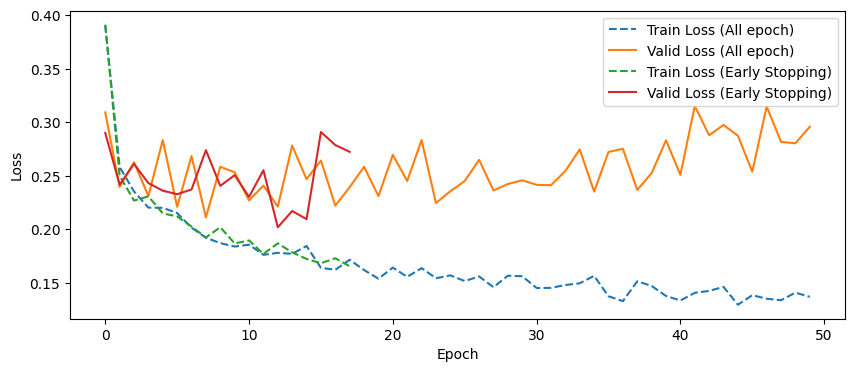

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L2 적용

In [26]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        weight_norm = sum(torch.norm(p).item() for p in model.parameters())
        weight_norms.append(weight_norm)

    return train_losses, val_losses, weight_norms

In [28]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses, weight_norms = \
    train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)
    
model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = \
    train_reg(model_reg, train_loader, val_loader, optim_reg)

Epoch 1 | Val Loss: 0.2617, Accuracy: 0.9197
Epoch 2 | Val Loss: 0.2026, Accuracy: 0.9367
Epoch 3 | Val Loss: 0.1466, Accuracy: 0.9553
Epoch 4 | Val Loss: 0.1479, Accuracy: 0.9533
Epoch 5 | Val Loss: 0.1448, Accuracy: 0.9560
Epoch 6 | Val Loss: 0.1135, Accuracy: 0.9650
Epoch 7 | Val Loss: 0.1079, Accuracy: 0.9679
Epoch 8 | Val Loss: 0.1154, Accuracy: 0.9665
Epoch 9 | Val Loss: 0.1078, Accuracy: 0.9666
Epoch 10 | Val Loss: 0.0943, Accuracy: 0.9733
Epoch 1 | Val Loss: 0.3134, Accuracy: 0.9052
Epoch 2 | Val Loss: 0.2635, Accuracy: 0.9234
Epoch 3 | Val Loss: 0.2592, Accuracy: 0.9236
Epoch 4 | Val Loss: 0.2152, Accuracy: 0.9398
Epoch 5 | Val Loss: 0.2072, Accuracy: 0.9437
Epoch 6 | Val Loss: 0.1950, Accuracy: 0.9476
Epoch 7 | Val Loss: 0.2179, Accuracy: 0.9349
Epoch 8 | Val Loss: 0.1919, Accuracy: 0.9464
Epoch 9 | Val Loss: 0.2129, Accuracy: 0.9440
Epoch 10 | Val Loss: 0.1933, Accuracy: 0.9462


In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss (No reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No reg)')
plt.plot(train_reg_losses, label='Train Loss (L2 Reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Val Loss (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,1)
plt.plot(weight_norms, label='Weight Norm (No reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()
